<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/Example_code_Python_for_models_with_a_binary_outcome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example code for models with a binary outcome

This notebook contains the code for different models predicting a binary outcome. There is no context to these examples: sometimes it just comes in handy to have these different approaches together in one place, to pick and choose from when running your own models.

In [41]:
#import relevant modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
#load the Sonar data, containing 60 attributes, with the aim to classify 
# objects as Mine or Rock
# more information to be found at: https://datahub.io/machine-learning/sonar
df = pd.read_csv('https://datahub.io/machine-learning/sonar/r/sonar.csv')
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock


In [3]:
#exploring the data I
df.describe()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.2

In [4]:
#exploring the data II
df.shape

(208, 61)

In [5]:
# exploring outcome data
df['Class'].value_counts()

Mine    111
Rock     97
Name: Class, dtype: int64

We split the data in a train and test set, while ensuring an equal distribution of the outcome variable in both sets.

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df['Class']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [7]:
#check if this resulted in a 70% train set and 30% test set with equal outcome distributions
print('share of observations in the train set:', str(round(len(strat_train_set)/len(df), 3)))
print('share of observations in the test set:', str(round(len(strat_test_set)/len(df), 3)))
print('share of mines in the train set:', str(round(len(strat_train_set.loc[strat_train_set['Class'] == 'Mine'])/len(strat_train_set), 3)))
print('share of mines in the test set:', str(round(len(strat_test_set.loc[strat_test_set['Class'] == 'Mine'])/len(strat_test_set), 3)))


share of observations in the train set: 0.697
share of observations in the test set: 0.303
share of mines in the train set: 0.531
share of mines in the test set: 0.54


In [8]:
# split features and outcome data
X_train = strat_train_set.loc[:,strat_train_set.columns != 'Class']
y_train = strat_train_set['Class']
X_test = strat_test_set.loc[:,strat_test_set.columns != 'Class']
y_test = strat_test_set['Class']



## Model 1: Logistic Regression

In [9]:
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)

LogisticRegression()

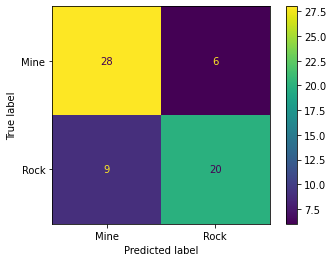

In [48]:
cm = confusion_matrix(y_test, log_clf.predict(X_test), labels=log_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_clf.classes_)
disp.plot()

In [11]:
accuracy_score(log_clf.predict(X_test), y_test)

0.7619047619047619

In [12]:
print('accuracy equals: ', str((28+20)/len(y_test)))

accuracy equals:  0.7619047619047619


# Model 2: LASSO

In [13]:
sc = StandardScaler()
X_train_prep = sc.fit_transform(X_train)
X_train_prep = pd.DataFrame(data = X_train_prep, columns = X_train.columns)
X_train_prep.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,attribute_11,attribute_12,attribute_13,attribute_14,attribute_15,attribute_16,attribute_17,attribute_18,attribute_19,attribute_20,attribute_21,attribute_22,attribute_23,attribute_24,attribute_25,attribute_26,attribute_27,attribute_28,attribute_29,attribute_30,attribute_31,attribute_32,attribute_33,attribute_34,attribute_35,attribute_36,attribute_37,attribute_38,attribute_39,attribute_40,attribute_41,attribute_42,attribute_43,attribute_44,attribute_45,attribute_46,attribute_47,attribute_48,attribute_49,attribute_50,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60
0,0.034283,0.067601,-0.540083,-1.216550,-1.170987,-0.701419,-0.516137,-0.268162,-0.688366,-0.999476,-1.452884,-0.924677,-0.671054,-0.604662,-0.310763,-0.702617,-0.645532,-0.649335,-0.729284,-0.317455,-0.299591,-0.008835,0.131029,0.311613,0.712183,0.849213,1.234418,0.990376,0.336450,0.242650,0.499052,0.119935,-0.673320,-1.005238,-0.880116,-0.472645,-0.376587,-0.094161,-0.227435,-0.676225,-0.813205,-0.203893,-0.267677,-0.296704,-0.355767,-0.682982,-0.169889,-0.020404,-0.357189,-0.867054,-0.652782,-0.663675,-0.450920,-0.007605,-0.567176,0.293379,-0.654754,-0.351269,-0.475797,0.409389
1,1.858457,0.744916,1.373396,-0.358238,-0.523457,-0.436807,-0.715491,-0.240968,0.468459,-0.183085,0.374547,1.164771,0.629917,-0.636518,-0.257037,0.016645,0.500725,0.756393,0.350793,-0.337814,-1.158652,-1.704743,-1.792821,-2.119814,-1.763306,-1.824993,-1.582754,-0.814761,0.300458,0.757940,1.346200,1.664721,1.237655,1.244888,1.375219,1.686245,2.300661,3.170289,2.803381,2.246552,2.196068,1.719033,1.492587,1.048330,-0.343992,-0.310525,0.067050,0.417722,0.143261,0.217290,-0.202379,0.072554,1.193419,-0.903566,-0.777689,-0.962169,-0.960487,1.190439,0.430963,0.258869
2,-0.413156,-0.874452,-0.317661,-0.726481,0.165531,0.824675,-0.099744,-0.858148,-0.399998,-0.534576,-1.206989,-1.597307,-1.022537,-0.021406,1.047592,1.663665,1.408736,1.217317,1.329867,1.193420,1.298597,1.248310,1.178522,1.341047,1.214272,1.009183,1.000330,0.258084,-0.726925,-1.127596,-0.410590,0.107458,-0.071446,-0.454020,-0.570032,-0.939609,-0.460671,-0.552751,-0.793482,-0.899058,-1.218376,-1.316296,-1.160146,-0.691140,-0.554093,-0.760258,-0.902746,-0.796152,-0.805106,-1.531405,0.202221,-0.063067,-0.325504,-0.572750,-0.679450,-0.317875,-0.510879,-0.365677,-0.122315,-0.211507
3,0.181790,-0.884766,-0.405976,0.173362,0.072745,-0.125597,-0.363406,-0.373390,-0.640584,0.054246,0.543161,0.661013,0.176234,-0.973614,-1.020131,-1.032105,-0.926566,-0.833340,-1.183992,-1.302128,-1.148293,-0.131912,0.729596,0.943510,1.281299,1.269187,1.039683,1.339393,1.141080,0.730304,1.223526,1.265470,0.549450,-0.828538,-1.167940,-0.959243,-1.059660,-1.047394,-0.708022,-1.542171,-0.807474,-1.171051,-0.952890,-0.375005,-0.677426,-1.101387,-0.501603,0.507231,0.334040,-0.210338,-0.843631,-0.702424,-0.158283,0.364563,-0.398765,-0.350915,-0.780644,-0.682664,-0.291371,0.033088
4,0.403051,0.153555,-0.343828,-0.576969,0.191196,0.513465,-0.088490,-0.793119,-1.374078,-1.183483,-1.157810,0.031317,-0.877524,-1.048910,-1.025836,-0.975586,-1.099538,-1.250176,-1.285769,-1.795052,-1.627630,-2.421627,-1.663861,-1.761406,-2.686063,-2.175546,-0.865073,0.131535,0.234472,0.298369,0.932810,0.459575,1.182052,2.005991,2.186749,2.239056,1.780555,1.618582,1.636097,2.054182,1.755938,1.295830,0.917346,0.052361,-0.325399,-0.599440,-0.486175,-0.282651,0.110082,-0.240883,-0.790193,-0.411807,0.775367,0.709164,-0.146149,-0.235273,1.035773,-0.178367,-0.045470,0.051904


In [35]:
logL1_clf = LogisticRegression(penalty='l1', solver='liblinear')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0.1, 20, 200)
grid = dict()
grid['C'] = lasso_alphas
gscv = GridSearchCV(logL1_clf, grid, scoring='accuracy', cv = cv, n_jobs=-1)
results = gscv.fit(X_train_prep, y_train)

In [36]:
results.best_estimator_

LogisticRegression(C=5.8999999999999995, penalty='l1', solver='liblinear')

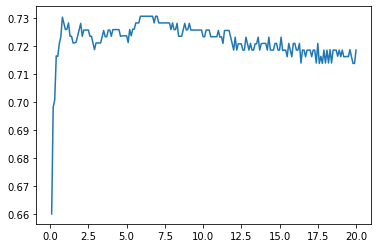

In [37]:
# plot accuracy for different values of C
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(lasso_alphas, results.cv_results_ ['mean_test_score'])

In [38]:
# get coefficients
results.best_estimator_.coef_

array([[-0.5342889 ,  0.        ,  1.06470796, -0.63883628,  0.        ,
         0.64075453,  0.        ,  4.68498054, -3.71146589, -1.36297405,
         0.        , -2.97752537,  0.        ,  0.        , -0.01666783,
         0.        ,  5.75097644, -4.04678074,  0.        , -1.21864117,
         0.        , -1.53576827,  0.        , -1.69100246,  0.        ,
         1.82952967,  0.        ,  0.        , -1.05357549, -2.26164576,
         4.93225585, -2.83344174,  0.00993248,  3.02427048, -1.58966759,
         0.        ,  2.92025452,  0.        , -1.52177481,  1.20238481,
         0.        ,  0.34207543, -1.85540144,  0.        , -0.83261591,
        -0.46487595,  0.        , -1.31618703, -3.39461722,  2.78480447,
        -2.11819516, -1.02225011, -0.34345383, -1.40148634,  1.63133262,
        -1.17719608,  0.10782427, -0.68022589,  0.        ,  0.40811846]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


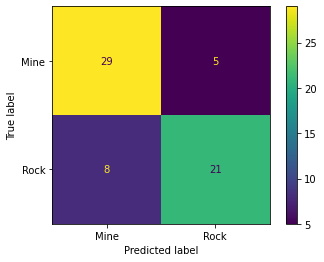

In [57]:
X_test_prep = sc.transform(X_test)
cm = confusion_matrix(y_test, results.best_estimator_.predict(X_test_prep), labels=results.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results.classes_)
disp.plot()

In [40]:
accuracy_score(results.predict(X_test_prep), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


0.7936507936507936

# Model 3: Random Forest

In [20]:
RF_clf = RandomForestClassifier()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
max_feat = np.linspace(1, len(X_train.columns), len(X_train.columns)).astype(int)
grid = dict()
grid['max_features'] = max_feat
gscv_rf = GridSearchCV(RF_clf, grid, scoring='accuracy', cv = cv, n_jobs=-1)
results_rf = gscv_rf.fit(X_train, y_train)

In [21]:
results_rf.best_estimator_

RandomForestClassifier(max_features=9)

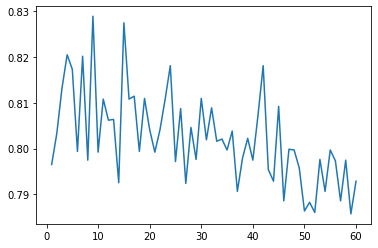

In [22]:
plt.plot(max_feat, results_rf.cv_results_ ['mean_test_score'])

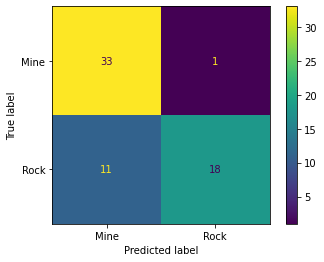

In [52]:
cm = confusion_matrix(y_test, results_rf.best_estimator_.predict(X_test), labels=results_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results_rf.classes_)
disp.plot()

In [53]:
accuracy_score(results_rf.predict(X_test), y_test)

0.8095238095238095

In [25]:
# plot feature importance
data = {'feature_names':X_train.columns, 'feature_importance':results_rf.best_estimator_.feature_importances_}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi_df

,feature_names,feature_importance
10,attribute_11,0.050917
9,attribute_10,0.043181
11,attribute_12,0.036141
47,attribute_48,0.033324
8,attribute_9,0.033177
12,attribute_13,0.033082
3,attribute_4,0.032081
51,attribute_52,0.028600
19,attribute_20,0.025995
14,attribute_15,0.025939


Text(0, 0.5, 'FEATURE NAMES')

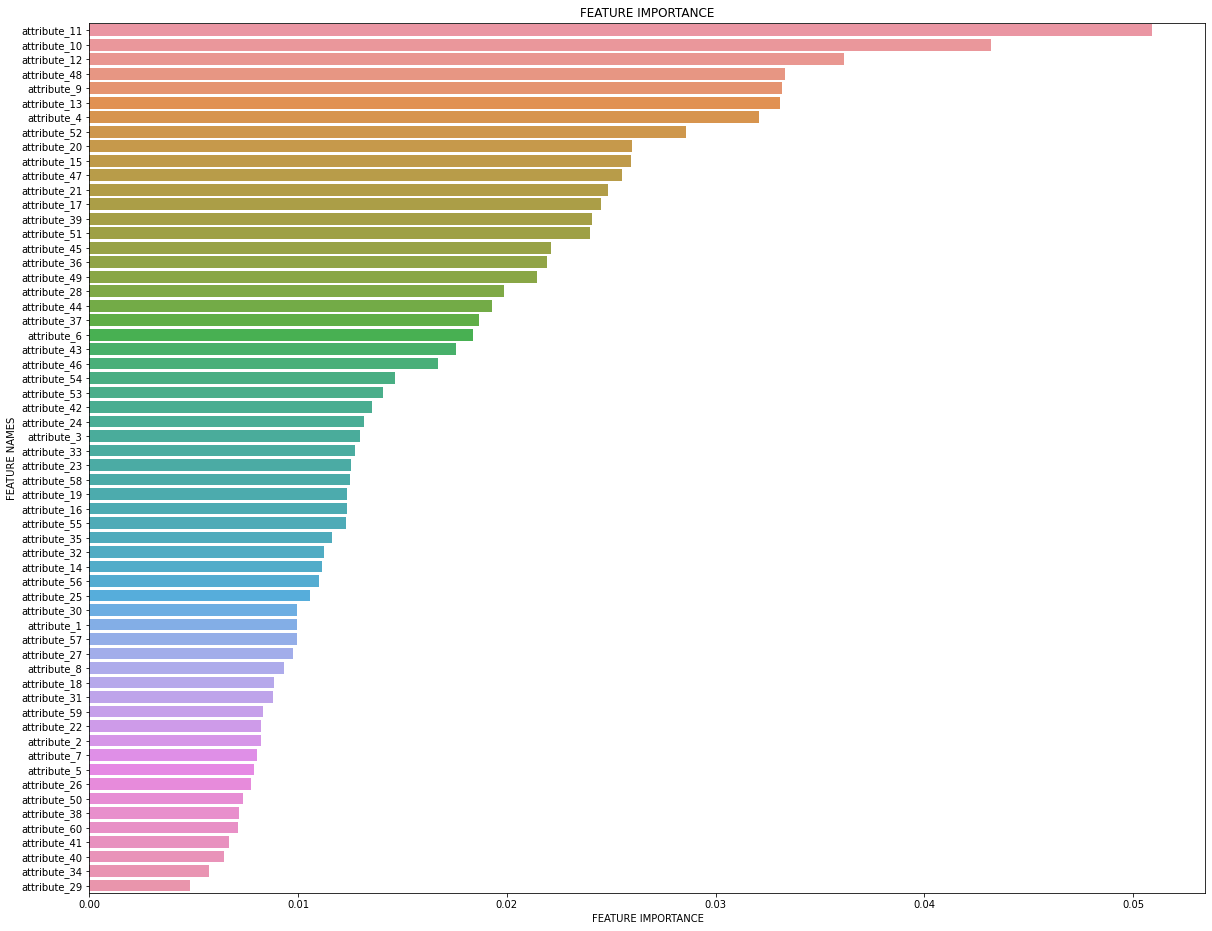

In [26]:
plt.figure(figsize=(20,16))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

# Model 4: Gradient Boosting

In [27]:
GB_clf = GradientBoostingClassifier(random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
max_feat = np.linspace(1, len(X_train.columns), 4).astype(int)
max_depth = np.linspace(1, 3, 3).astype(int)
n_estimators = np.linspace(50, 300, 6).astype(int)
grid = dict()
grid['max_features'] = max_feat
grid['max_depth'] = max_depth
grid['n_estimators'] = n_estimators
grid

{'max_depth': array([1, 2, 3]),
 'max_features': array([ 1, 20, 40, 60]),
 'n_estimators': array([ 50, 100, 150, 200, 250, 300])}

In [28]:
gscv_gb = GridSearchCV(GB_clf, grid, scoring='accuracy', cv = cv, n_jobs=-1)
results_gb = gscv_gb.fit(X_train, y_train)

In [29]:
results_gb.best_estimator_

GradientBoostingClassifier(max_depth=2, max_features=60, n_estimators=300,
                           random_state=42)

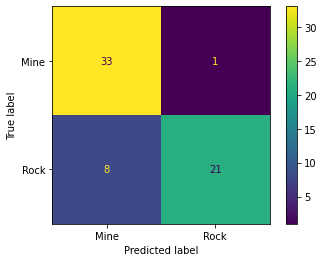

In [55]:
cm = confusion_matrix(y_test, results_gb.best_estimator_.predict(X_test), labels=results_gb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results_gb.classes_)
disp.plot()

In [31]:
accuracy_score(results_gb.predict(X_test), y_test)

0.8571428571428571

In [32]:
# plot feature importance
data = {'feature_names':X_train.columns, 'feature_importance':results_gb.best_estimator_.feature_importances_}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi_df

,feature_names,feature_importance
9,attribute_10,1.095743e-01
11,attribute_12,9.715970e-02
35,attribute_36,6.595331e-02
50,attribute_51,6.495469e-02
3,attribute_4,6.131020e-02
19,attribute_20,6.130940e-02
43,attribute_44,5.067298e-02
44,attribute_45,4.886327e-02
38,attribute_39,4.766252e-02
14,attribute_15,4.128314e-02


Text(0, 0.5, 'FEATURE NAMES')

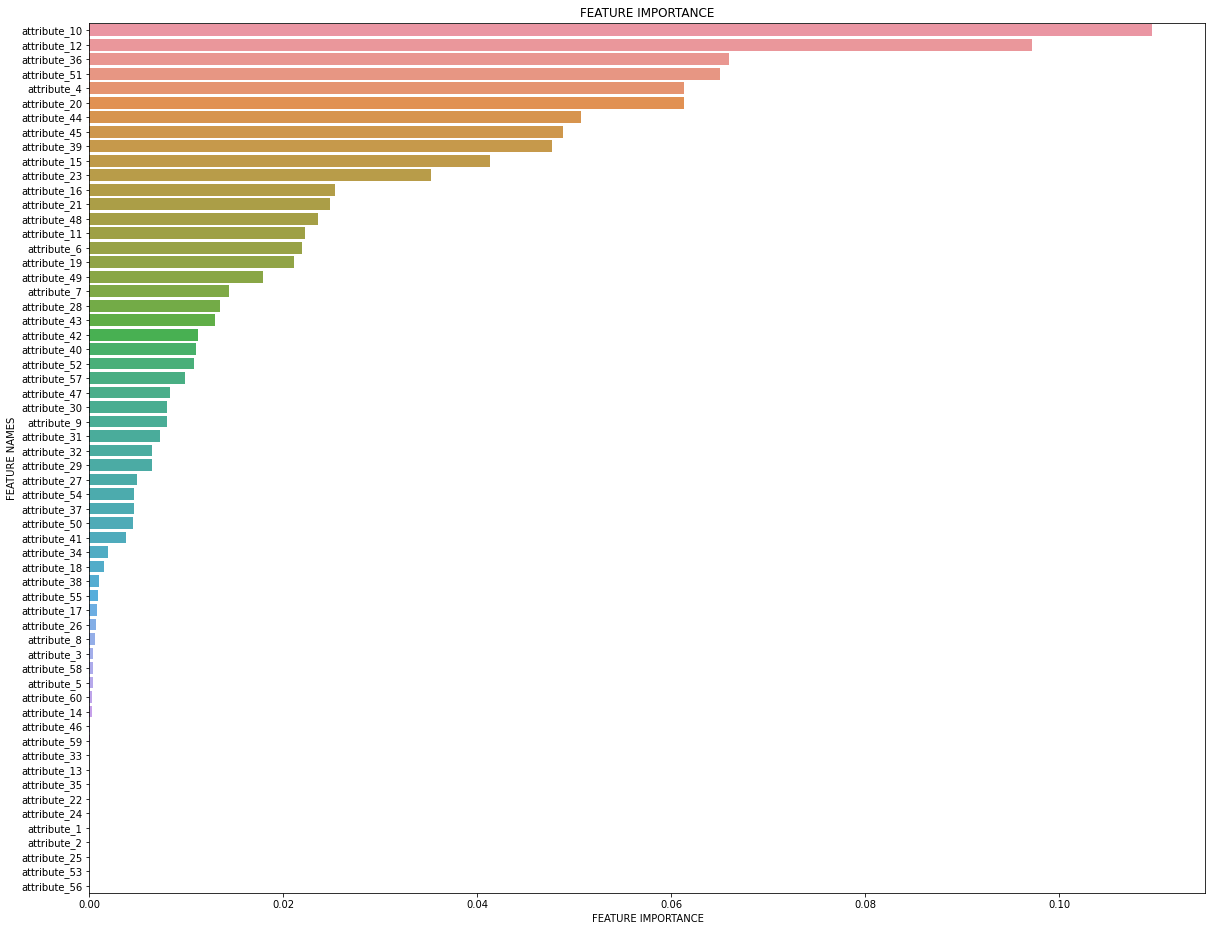

In [33]:
plt.figure(figsize=(20,16))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

# To conclude
You could speed up the process of trying out different models on your own data by making use of this example code.